In [1]:
import os
from tf_version.kl import mvn_kl
import numpy as np
from ml_tools.tf_kernels import ard_rbf_kernel
import tensorflow as tf
tf.enable_eager_execution()
from scipy.stats import norm

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
# Let's make a really simple example.
np.random.seed(2)
x = tf.constant(np.random.uniform(-2, 2, size=50).reshape(-1, 1))

In [3]:
lscale = tf.Variable(np.reshape(np.random.uniform(1, 5), (1,)))
alpha = tf.Variable(2., dtype=tf.float64)

k_true = ard_rbf_kernel(x, x, lscale, alpha, jitter=0)

W0918 13:17:47.419278 4566529472 deprecation_wrapper.py:119] From /Users/ingramm/Projects/uni_melb/ml_tools/ml_tools/tf_kernels.py:30: The name tf.matrix_set_diag is deprecated. Please use tf.linalg.set_diag instead.

W0918 13:17:47.420218 4566529472 deprecation_wrapper.py:119] From /Users/ingramm/Projects/uni_melb/ml_tools/ml_tools/tf_kernels.py:30: The name tf.matrix_diag_part is deprecated. Please use tf.linalg.diag_part instead.



In [4]:
draw = np.random.multivariate_normal(np.zeros(x.shape[0]), k_true.numpy())

draw

array([ 0.43345871, -0.2805535 ,  0.65014624,  0.43212719,  0.40246706,
        0.22438612, -0.00866964,  0.76690553,  0.16513574,  0.10321981,
        0.76977992,  0.61283344, -0.12457658,  0.58385732, -0.04327786,
        0.95081063,  0.97351537,  0.54716407,  0.97280428, -0.20709582,
        0.5681362 , -0.22742614,  0.41785954, -0.18253142, -0.13616026,
        0.73102737,  0.02889175, -0.16702576,  0.01876451,  0.26256544,
        0.49600162, -0.01370176,  0.79862517,  0.52568433,  0.56811841,
        0.33591472,  0.95542911,  0.70311274, -0.08011411,  0.8771279 ,
        0.93098503,  0.55818551,  0.97081802,  0.24643616,  0.68101404,
        0.41671617,  0.43494781,  0.94539257,  0.62469957,  0.93962209])

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

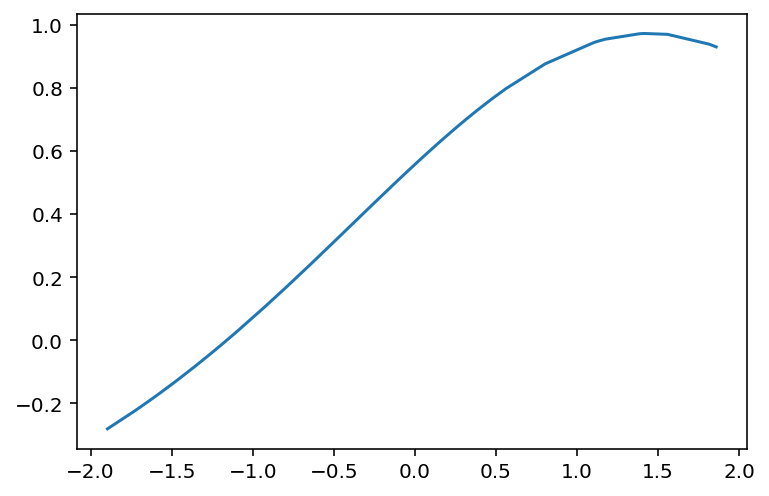

In [6]:
order = np.argsort(x.numpy()[:, 0])

plt.plot(x.numpy()[order], draw[order])

In [7]:
# Draw some data
probs = norm.cdf(draw)

In [8]:
y = tf.constant(np.random.binomial(1, probs), dtype=tf.float64)

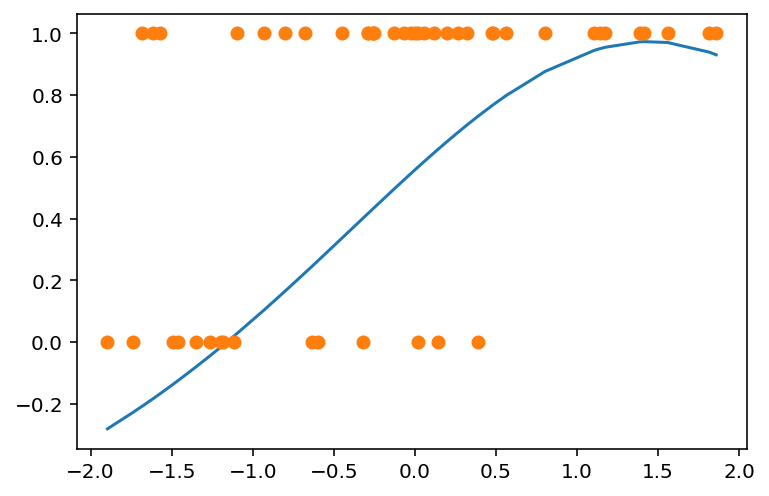

In [9]:
plt.plot(x.numpy()[order], draw[order])
plt.plot(x.numpy()[order], y.numpy()[order], marker='o', linestyle='none')

In [10]:
# Great. I have my input data x, and my outcomes y.

In [11]:
from svgp import get_starting_m_and_l
from ml_tools.lin_alg import num_triangular_elts

In [12]:
n_inducing = 10

m = tf.zeros(n_inducing, dtype=tf.float64)
n_elts = num_triangular_elts(n_inducing)
L_elts = tf.Variable(np.random.randn(n_elts))
indices = np.array(np.tril_indices(n_inducing)).T

L = tf.scatter_nd(indices, L_elts, (n_inducing, n_inducing))

In [13]:
Z = tf.constant(np.random.uniform(-2, 2, 10).reshape(-1, 1))
#Z = x

In [14]:
from tf_version.quadrature import expectation
from tf_version.likelihoods import bernoulli_probit_lik
from tf_version.svgp import (project_to_f, compute_qf_mean_cov, 
                             compute_kl_term, compute_objective, extract_params)
from functools import partial

In [15]:
kernel_fn = partial(ard_rbf_kernel, lengthscales=lscale, alpha=alpha)

In [16]:
mean, cov = compute_qf_mean_cov(L, m, x, Z, kernel_fn)

In [17]:
expectation(y, tf.diag_part(cov), mean, bernoulli_probit_lik)

W0918 13:17:48.319694 4566529472 deprecation.py:323] From /anaconda2/envs/jax/lib/python3.7/site-packages/tensorflow_probability/python/internal/special_math.py:154: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=329, shape=(50,), dtype=float64, numpy=
array([ -1.68471214, -22.4692249 ,  -3.13588188,  -1.36265878,
        -2.26699404,  -1.29428261,  -2.17942617,  -3.65727981,
        -1.23949781,  -1.28245745,  -1.2881534 ,  -1.52042092,
        -3.6131087 ,  -1.52874906,  -1.66886162,  -1.15249769,
        -1.11339719,  -1.52167258,  -1.12202513,  -9.34983517,
        -1.52807918, -11.93794978,  -1.36791782,  -6.98328535,
        -4.1022171 ,  -1.36671521,  -1.09256228,  -5.82541   ,
        -1.13944323,  -1.07535559,  -1.48164942,  -1.35499889,
        -1.22937542,  -1.50887855,  -1.52807639,  -1.21274599,
        -1.15530968,  -1.41774921,  -2.29651599,  -1.11857811,
        -2.79711114,  -1.52581141,  -1.12480212,  -1.04824997,
        -1.45268825,  -1.36591496,  -1.39692217,  -1.14770598,
        -1.5134048 ,  -2.27148062])>

In [18]:
compute_kl_term(m, L, Z, kernel_fn)

<tf.Tensor: id=402, shape=(), dtype=float64, numpy=1170084.5764976614>

In [19]:
with tf.GradientTape() as tape:
    
    tape.watch(m)

    result = compute_objective(x, y, m, L, Z, bernoulli_probit_lik, kernel_fn)

In [20]:
grad = tape.gradient(result, m)

In [21]:
result

<tf.Tensor: id=746, shape=(), dtype=float64, numpy=-1170215.3945393043>

In [22]:
grad

<tf.Tensor: id=1913, shape=(10,), dtype=float64, numpy=
array([  0.70106538,  -2.99398336,   6.28185353,   0.89313617,
         0.07642525,   7.23766085,   5.12477415,   8.10754152,
       -14.26126456,   7.69072641])>

In [23]:
from ml_tools.lin_alg import num_triangular_elts

theta = tf.Variable(np.concatenate([
    np.random.randn(n_inducing),
    np.random.randn(num_triangular_elts(n_inducing)),
    np.reshape(1., (-1,)),
    np.reshape(3., (-1,))
]))

In [24]:
m, L, kern_params = extract_params(theta, n_inducing)

In [25]:
def rbf_bernoulli_objective(theta):
    
    m, L, kern_params = extract_params(
        theta, n_inducing, square_kern_params=True)
    
    kern_fn = partial(
        ard_rbf_kernel, alpha=kern_params[0],
        lengthscales=kern_params[1:], jitter=1e-5)
    
    cur_objective = -compute_objective(
        x, y, m, L, Z, bernoulli_probit_lik, kern_fn)
    
    return cur_objective

In [26]:
def to_optimize(theta):
    
    theta = tf.Variable(theta, dtype=tf.float64)
    
    with tf.GradientTape() as tape:
    
        tape.watch(theta)
        objective = rbf_bernoulli_objective(theta)
        
    grad = tape.gradient(objective, theta)
    
    print(objective)
        
    return objective.numpy(), grad.numpy()

In [27]:
start_theta = np.concatenate([
    np.random.randn(n_inducing),
    np.random.randn(num_triangular_elts(n_inducing)),
    np.reshape(1., (-1,)),
    np.reshape(3., (-1,))
])

In [28]:
from scipy.optimize import minimize

In [29]:
result = minimize(to_optimize, start_theta, jac=True)

tf.Tensor(2378221.348055083, shape=(), dtype=float64)
tf.Tensor(2378221.348055083, shape=(), dtype=float64)
tf.Tensor(1761270.9534194195, shape=(), dtype=float64)
tf.Tensor(99809.43854047437, shape=(), dtype=float64)
tf.Tensor(713441.2773617211, shape=(), dtype=float64)
tf.Tensor(639352.6180304941, shape=(), dtype=float64)
tf.Tensor(159444.15722018183, shape=(), dtype=float64)
tf.Tensor(11532478.54908263, shape=(), dtype=float64)
tf.Tensor(134993.01586087528, shape=(), dtype=float64)
tf.Tensor(169708.28603855945, shape=(), dtype=float64)
tf.Tensor(128072.81426869825, shape=(), dtype=float64)
tf.Tensor(117868.30653486271, shape=(), dtype=float64)
tf.Tensor(107278.98390169562, shape=(), dtype=float64)
tf.Tensor(124261.79977966583, shape=(), dtype=float64)
tf.Tensor(104311.92822166855, shape=(), dtype=float64)
tf.Tensor(99914.92856846243, shape=(), dtype=float64)
tf.Tensor(92124.4314380151, shape=(), dtype=float64)
tf.Tensor(78415.20853393027, shape=(), dtype=float64)
tf.Tensor(55705.6369

tf.Tensor(89.10797198439211, shape=(), dtype=float64)
tf.Tensor(87.55818012948276, shape=(), dtype=float64)
tf.Tensor(86.1854036607561, shape=(), dtype=float64)
tf.Tensor(85.23271627376383, shape=(), dtype=float64)
tf.Tensor(84.2356799309554, shape=(), dtype=float64)
tf.Tensor(83.8820988868468, shape=(), dtype=float64)
tf.Tensor(83.43157735544573, shape=(), dtype=float64)
tf.Tensor(83.06221249429908, shape=(), dtype=float64)
tf.Tensor(82.86839727630019, shape=(), dtype=float64)
tf.Tensor(82.62076631064197, shape=(), dtype=float64)
tf.Tensor(82.47844734244904, shape=(), dtype=float64)
tf.Tensor(82.35624118901303, shape=(), dtype=float64)
tf.Tensor(82.23295853477737, shape=(), dtype=float64)
tf.Tensor(82.0843579341636, shape=(), dtype=float64)
tf.Tensor(81.90373732286523, shape=(), dtype=float64)
tf.Tensor(81.74537662154168, shape=(), dtype=float64)
tf.Tensor(81.54190533771049, shape=(), dtype=float64)
tf.Tensor(81.24928795375757, shape=(), dtype=float64)
tf.Tensor(80.91476717347174, sha

tf.Tensor(57.297214599044, shape=(), dtype=float64)
tf.Tensor(57.09828405565986, shape=(), dtype=float64)
tf.Tensor(56.90467884594603, shape=(), dtype=float64)
tf.Tensor(56.74723533755939, shape=(), dtype=float64)
tf.Tensor(56.536703748661495, shape=(), dtype=float64)
tf.Tensor(56.412958183166076, shape=(), dtype=float64)
tf.Tensor(56.37892485322674, shape=(), dtype=float64)
tf.Tensor(56.37112168192431, shape=(), dtype=float64)
tf.Tensor(56.359853416080455, shape=(), dtype=float64)
tf.Tensor(56.34712553960233, shape=(), dtype=float64)
tf.Tensor(56.34207791130098, shape=(), dtype=float64)
tf.Tensor(56.33850597181734, shape=(), dtype=float64)
tf.Tensor(56.33604191051411, shape=(), dtype=float64)
tf.Tensor(56.33341261033589, shape=(), dtype=float64)
tf.Tensor(56.32921811668535, shape=(), dtype=float64)
tf.Tensor(56.322822496916515, shape=(), dtype=float64)
tf.Tensor(56.31329699610127, shape=(), dtype=float64)
tf.Tensor(56.29793992507975, shape=(), dtype=float64)
tf.Tensor(56.2716766617700

tf.Tensor(52.41781129832763, shape=(), dtype=float64)
tf.Tensor(52.34960574481627, shape=(), dtype=float64)
tf.Tensor(52.32819659964398, shape=(), dtype=float64)
tf.Tensor(52.299901945022505, shape=(), dtype=float64)
tf.Tensor(52.26960706352148, shape=(), dtype=float64)
tf.Tensor(52.228273878257305, shape=(), dtype=float64)
tf.Tensor(52.19102809379621, shape=(), dtype=float64)
tf.Tensor(52.13279088404246, shape=(), dtype=float64)
tf.Tensor(52.04220845014156, shape=(), dtype=float64)
tf.Tensor(51.90421495534053, shape=(), dtype=float64)
tf.Tensor(51.76968463150821, shape=(), dtype=float64)
tf.Tensor(51.61304584976647, shape=(), dtype=float64)
tf.Tensor(51.511265657465245, shape=(), dtype=float64)
tf.Tensor(51.36040697469602, shape=(), dtype=float64)
tf.Tensor(51.24185085855579, shape=(), dtype=float64)
tf.Tensor(51.06197832529912, shape=(), dtype=float64)
tf.Tensor(50.803531030051886, shape=(), dtype=float64)
tf.Tensor(50.629528670705895, shape=(), dtype=float64)
tf.Tensor(50.5625293799

tf.Tensor(41.36953448305271, shape=(), dtype=float64)
tf.Tensor(41.3582616969815, shape=(), dtype=float64)
tf.Tensor(41.32520276639643, shape=(), dtype=float64)
tf.Tensor(41.34360491701616, shape=(), dtype=float64)
tf.Tensor(41.30902784391576, shape=(), dtype=float64)
tf.Tensor(41.28672693916199, shape=(), dtype=float64)
tf.Tensor(41.25789554450212, shape=(), dtype=float64)
tf.Tensor(41.218915323655494, shape=(), dtype=float64)
tf.Tensor(41.18748402863302, shape=(), dtype=float64)
tf.Tensor(41.165448592571984, shape=(), dtype=float64)
tf.Tensor(41.13412755727455, shape=(), dtype=float64)
tf.Tensor(41.10590803830654, shape=(), dtype=float64)
tf.Tensor(41.07521058774897, shape=(), dtype=float64)
tf.Tensor(41.0626699666095, shape=(), dtype=float64)
tf.Tensor(41.050642695928175, shape=(), dtype=float64)
tf.Tensor(41.04317832653203, shape=(), dtype=float64)
tf.Tensor(41.03842157394375, shape=(), dtype=float64)
tf.Tensor(41.03788437259673, shape=(), dtype=float64)
tf.Tensor(41.03560986564258

tf.Tensor(33.234667578946485, shape=(), dtype=float64)
tf.Tensor(30.51994222833775, shape=(), dtype=float64)
tf.Tensor(30.07664595673962, shape=(), dtype=float64)
tf.Tensor(30.24932495351204, shape=(), dtype=float64)
tf.Tensor(29.884862553746217, shape=(), dtype=float64)
tf.Tensor(29.716976470542868, shape=(), dtype=float64)
tf.Tensor(29.741615931630008, shape=(), dtype=float64)
tf.Tensor(29.627375221392654, shape=(), dtype=float64)
tf.Tensor(29.558665675333955, shape=(), dtype=float64)
tf.Tensor(29.51537634074001, shape=(), dtype=float64)
tf.Tensor(29.485728339204663, shape=(), dtype=float64)
tf.Tensor(29.464567512409396, shape=(), dtype=float64)
tf.Tensor(29.43679066576945, shape=(), dtype=float64)
tf.Tensor(29.428510537853256, shape=(), dtype=float64)
tf.Tensor(29.41576186767327, shape=(), dtype=float64)
tf.Tensor(29.40006741160219, shape=(), dtype=float64)
tf.Tensor(29.394241571350005, shape=(), dtype=float64)
tf.Tensor(29.38691559509528, shape=(), dtype=float64)
tf.Tensor(29.38527

tf.Tensor(28.302648281417298, shape=(), dtype=float64)
tf.Tensor(28.302682162088725, shape=(), dtype=float64)
tf.Tensor(28.302642184039037, shape=(), dtype=float64)
tf.Tensor(28.302633392338027, shape=(), dtype=float64)
tf.Tensor(28.302626647045955, shape=(), dtype=float64)
tf.Tensor(28.302619694141324, shape=(), dtype=float64)
tf.Tensor(28.30260664510088, shape=(), dtype=float64)
tf.Tensor(28.302581971938967, shape=(), dtype=float64)
tf.Tensor(28.30253611663806, shape=(), dtype=float64)
tf.Tensor(28.302456093756298, shape=(), dtype=float64)
tf.Tensor(28.302341479438397, shape=(), dtype=float64)
tf.Tensor(28.302231865159904, shape=(), dtype=float64)
tf.Tensor(28.30220742227248, shape=(), dtype=float64)
tf.Tensor(28.302161764357976, shape=(), dtype=float64)
tf.Tensor(28.302042800336938, shape=(), dtype=float64)
tf.Tensor(28.301876017915546, shape=(), dtype=float64)
tf.Tensor(28.30181959106452, shape=(), dtype=float64)
tf.Tensor(28.301815888141444, shape=(), dtype=float64)
tf.Tensor(28.3

tf.Tensor(27.952370443840806, shape=(), dtype=float64)
tf.Tensor(27.947159228446527, shape=(), dtype=float64)
tf.Tensor(27.940165788834854, shape=(), dtype=float64)
tf.Tensor(27.932061181086215, shape=(), dtype=float64)
tf.Tensor(27.925735954319602, shape=(), dtype=float64)
tf.Tensor(27.916869594388167, shape=(), dtype=float64)
tf.Tensor(27.90359149852653, shape=(), dtype=float64)
tf.Tensor(27.892364953766617, shape=(), dtype=float64)
tf.Tensor(27.884571696225105, shape=(), dtype=float64)
tf.Tensor(27.87767035205282, shape=(), dtype=float64)
tf.Tensor(27.871345363913917, shape=(), dtype=float64)
tf.Tensor(27.867798245966277, shape=(), dtype=float64)
tf.Tensor(27.864601963997824, shape=(), dtype=float64)
tf.Tensor(27.860374992035343, shape=(), dtype=float64)
tf.Tensor(27.858068910786763, shape=(), dtype=float64)
tf.Tensor(27.855464998952822, shape=(), dtype=float64)
tf.Tensor(27.85398649381074, shape=(), dtype=float64)
tf.Tensor(27.851825482055666, shape=(), dtype=float64)
tf.Tensor(27.

In [30]:
m, L, kern_params = extract_params(result.x, n_inducing)
L = L.numpy()

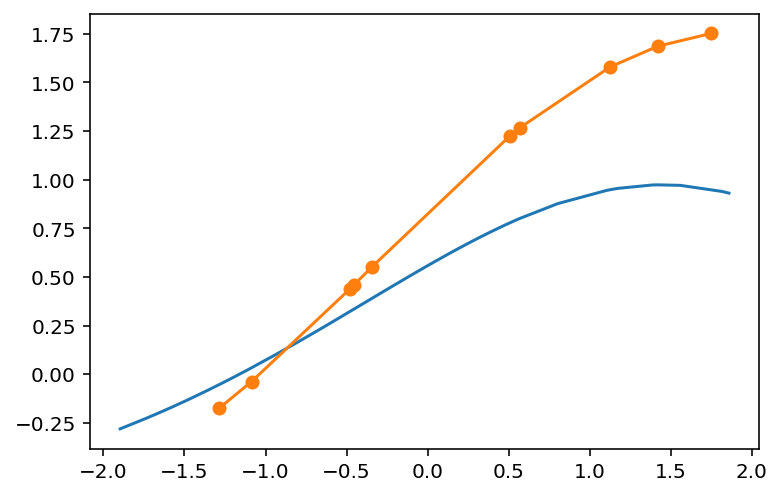

In [31]:
order = np.argsort(x.numpy()[:, 0])
z_order = np.argsort(Z.numpy()[:, 0])

plt.plot(x.numpy()[order], draw[order])
plt.plot(Z.numpy()[z_order], m[z_order], marker='o')

In [32]:
m

array([-0.03729152,  1.22332135,  0.55298882,  1.75140245,  1.26750206,
        0.46092381,  1.68616696,  0.44060836, -0.17530485,  1.58008984])

In [33]:
import gpflow

W0918 13:19:31.204438 4566529472 deprecation_wrapper.py:119] From /anaconda2/envs/jax/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0918 13:19:31.206586 4566529472 deprecation_wrapper.py:119] From /anaconda2/envs/jax/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0918 13:19:31.461126 4566529472 deprecation_wrapper.py:119] From /anaconda2/envs/jax/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:169: The name tf.train.AdadeltaOptimizer is deprecated. Please use tf.compat.v1.train.AdadeltaOptimizer instead.

W0918 13:19:31.462091 4566529472 deprecation_wrapper.py:119] From /anaconda2/envs/jax/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:156: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0918 13:19:31.462829 4566529472 deprecation_

In [34]:
tf.disable_eager_execution()
gpflow.reset_default_graph_and_session()

kern = gpflow.kernels.RBF(input_dim=1, ARD=True)

W0918 13:19:31.511297 4566529472 deprecation_wrapper.py:119] From /anaconda2/envs/jax/lib/python3.7/site-packages/gpflow/session_manager.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



In [35]:
model = gpflow.models.SVGP(x.numpy(), y.numpy().reshape(-1, 1), kern, gpflow.likelihoods.Bernoulli(),
                           Z=Z.numpy(), whiten=False)

model.feature.set_trainable(False)

W0918 13:19:31.943614 4566529472 deprecation.py:323] From /anaconda2/envs/jax/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3744: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


In [51]:
opt = gpflow.train.ScipyOptimizer(options={'maxfun': int(1E6)})

In [52]:
opt.minimize(model, maxiter=int(1E6))

In [53]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(10, 1)",True,"[[-1.0855589926676044], [0.5053758368041055], ..."
SVGP/kern/lengthscales,Parameter,None,+ve,True,"(1,)",True,[2.280194958874687]
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.9971560140592763
SVGP/q_mu,Parameter,None,(none),True,"(10, 1)",True,"[[-0.039211183071634514], [1.2378446737741358]..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 10, 10)",True,"[[[0.257287505566026, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [54]:
q_mu_gpflow = model.as_pandas_table().loc['SVGP/q_mu'].value

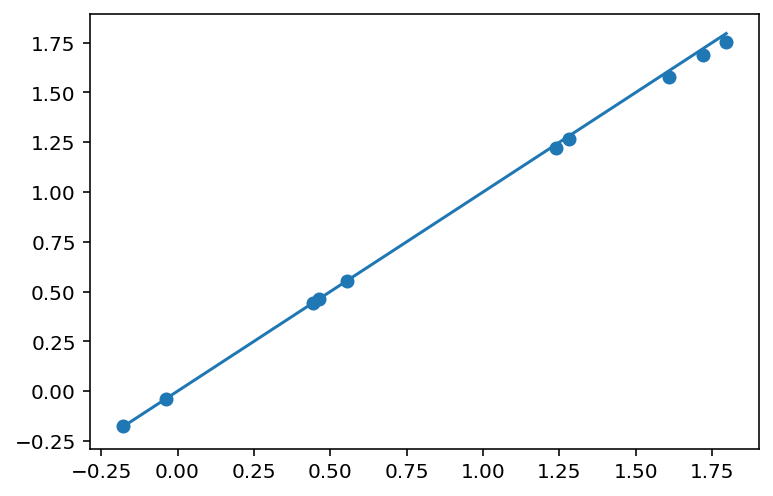

In [55]:
plt.scatter(q_mu_gpflow, m)
plt.plot([q_mu_gpflow.min(), q_mu_gpflow.max()], [q_mu_gpflow.min(), q_mu_gpflow.max()])

In [56]:
q_sqrt_gpflow = model.as_pandas_table().loc['SVGP/q_sqrt'].value[0]

In [57]:
q_sqrt_elts = q_sqrt_gpflow[np.tril_indices_from(q_sqrt_gpflow)]

In [58]:
L_elts = L[np.tril_indices_from(L)]

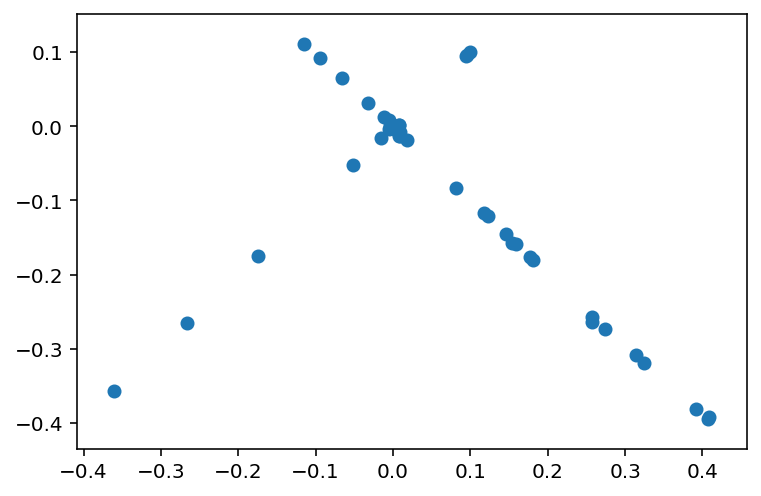

In [59]:
plt.scatter(q_sqrt_elts, L_elts)

In [60]:
q_sqrt_diag = np.diag(q_sqrt_gpflow)

In [61]:
l_diag = np.diag(L)

In [62]:
my_cov = L @ L.T

In [63]:
gpf_cov = q_sqrt_gpflow @ q_sqrt_gpflow.T

In [66]:
np.diag(my_cov)

array([0.06598184, 0.09571021, 0.05630004, 0.36346738, 0.10202163,
       0.055245  , 0.25946087, 0.05510972, 0.07852473, 0.18758967])

In [67]:
np.diag(gpf_cov)

array([0.06619686, 0.09889046, 0.05667363, 0.37617222, 0.10555011,
       0.05547898, 0.26920077, 0.05531868, 0.07893029, 0.19488057])

Text(0, 0.5, 'GPFlow covariance')

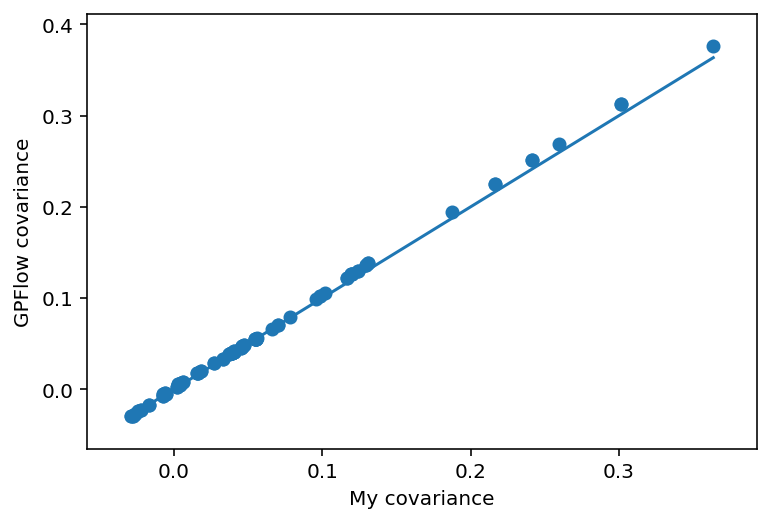

In [73]:
plt.scatter(my_cov.reshape(-1), gpf_cov.reshape(-1))
plt.plot([my_cov.min(), my_cov.max()], [my_cov.min(), my_cov.max()])
plt.xlabel('My covariance')
plt.ylabel('GPFlow covariance')

In [70]:
kern_params

array([1.37980045, 2.23430166])

In [71]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(10, 1)",True,"[[-1.0855589926676044], [0.5053758368041055], ..."
SVGP/kern/lengthscales,Parameter,None,+ve,True,"(1,)",True,[2.280194958874687]
SVGP/kern/variance,Parameter,None,+ve,True,(),True,1.9971560140592763
SVGP/q_mu,Parameter,None,(none),True,"(10, 1)",True,"[[-0.039211183071634514], [1.2378446737741358]..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 10, 10)",True,"[[[0.257287505566026, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [72]:
kern_params[0]**2

1.9038492730617296